In [185]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [186]:
# Define paths to your dataset
dataset_path = r"D:\fas\fashion-dataset"  # Update this with the path to your dataset
image_folder = os.path.join(dataset_path, "images")
annotations_file = os.path.join(dataset_path, "styles.csv")

In [187]:
from sklearn.preprocessing import LabelEncoder


annotations = {}  
label_encoder = LabelEncoder()

with open(annotations_file, 'r') as file:
    next(file)  
    for line in file:
        parts = line.strip().split(',')
        filename = parts[0]
        label = parts[1]
        label_encoded = label_encoder.fit_transform([label])[0] 
        annotations[filename] = label_encoded

In [188]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the directory containing the styles.csv file
path = 'D:\\fas\\fashion-dataset\\'

# Read styles.csv and drop bad lines
styles_df = pd.read_csv(path + "styles.csv", nrows=6000)

# Make image column contain (id.jpg)
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)

print(styles_df.shape)
styles_df.head(5)


(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [189]:
styles_df['articleType'].unique()

array(['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks',
       'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra',
       'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant',
       'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',
       'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',
       'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',
       'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',
       'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',
       'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',
       'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',
       'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',
       'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',
       'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag',
       'Tracksuits', 'S

In [190]:
styles_df.articleType.value_counts().sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  14,  15,
        16,  18,  19,  20,  21,  22,  23,  25,  27,  30,  31,  32,  33,
        34,  40,  42,  48,  52,  57,  61,  62,  67,  74,  75,  76,  77,
        84,  87,  88,  94, 112, 118, 121, 122, 125, 134, 184, 234, 238,
       272, 311, 366, 375, 417, 900], dtype=int64)

<Axes: ylabel='articleType'>

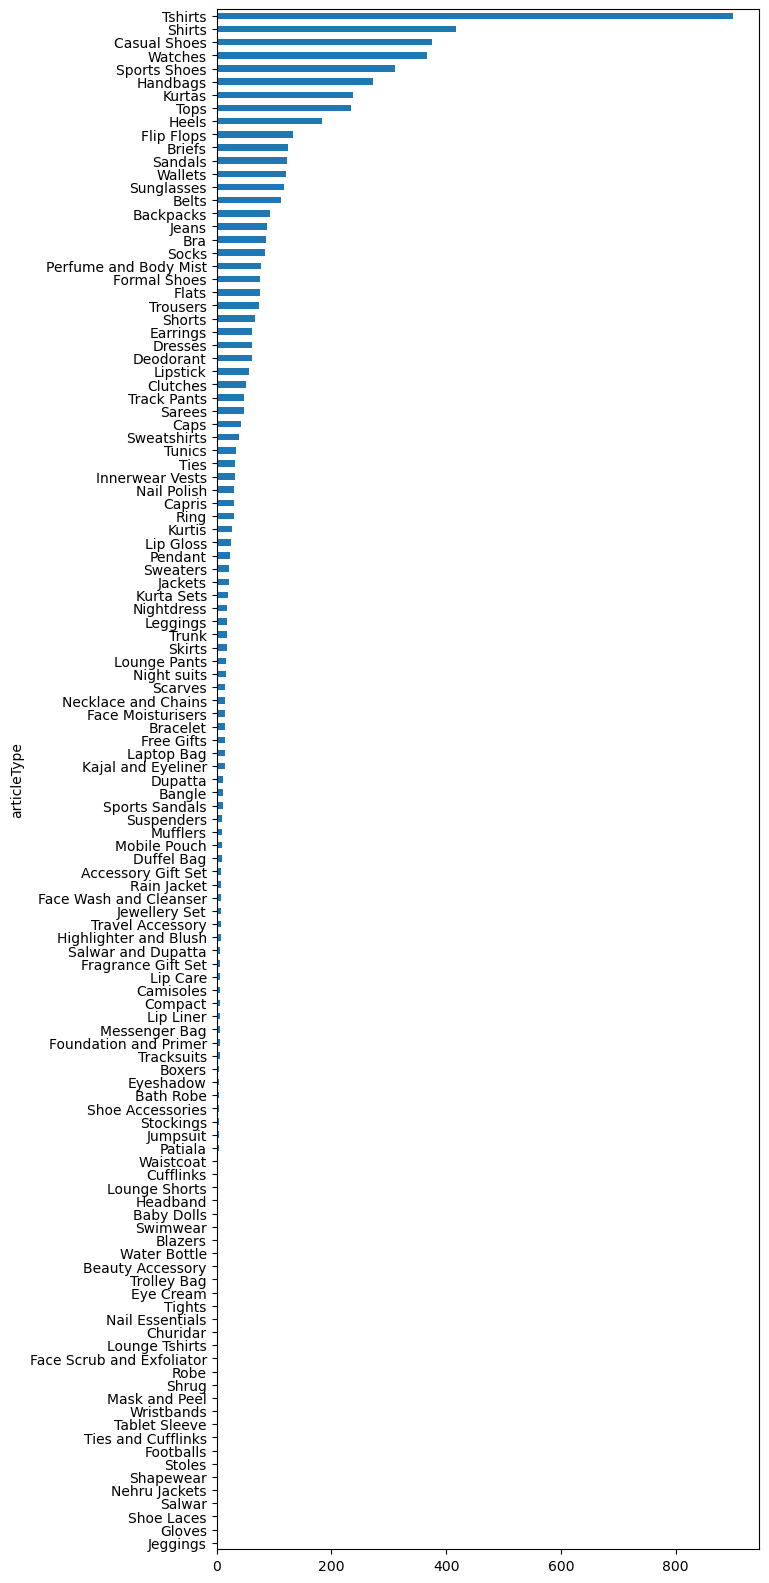

In [191]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

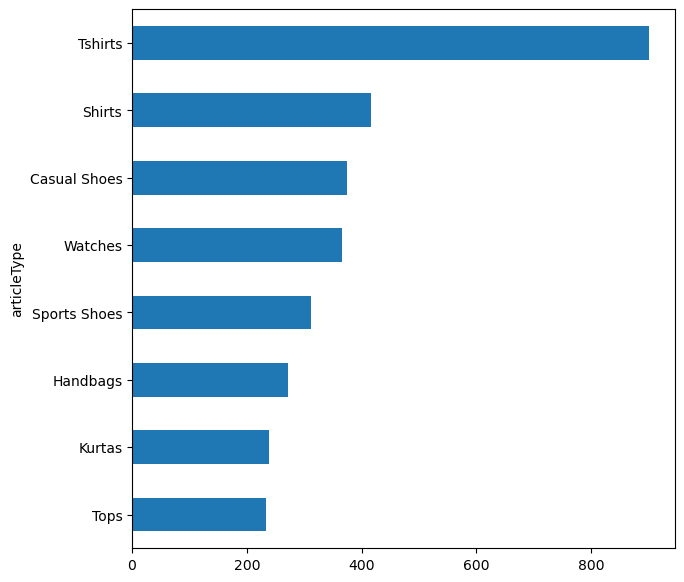

In [192]:
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = styles_df['articleType'].value_counts()

# Filter out categories with at least 200 occurrences
valid_categories = category_counts[category_counts >= 200].index

# Filter the DataFrame to include only rows with valid categories
filtered_df = styles_df[styles_df['articleType'].isin(valid_categories)]

# Plot the filtered DataFrame
plt.figure(figsize=(7, 7))
filtered_df['articleType'].value_counts().sort_values().plot(kind='barh')
plt.show()



In [193]:
import pandas as pd


max_count = 230

def downsample_group(group):
    if len(group) > max_count:
        return group.sample(n=max_count, random_state=1)
    return group


balanced_df = filtered_df.groupby('articleType').apply(downsample_group).reset_index(drop=True)


print(balanced_df['articleType'].value_counts())

articleType
Casual Shoes    230
Handbags        230
Kurtas          230
Shirts          230
Sports Shoes    230
Tops            230
Tshirts         230
Watches         230
Name: count, dtype: int64


In [194]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

image_directory = 'D:\\fas\\fashion-dataset\\images\\'  
target_size = (128, 128)

def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Ensure the image has three channels (for RGB images)
    if img_array.shape[-1] != 3:
        img_array = np.expand_dims(img_array, axis=-1)  # Add single channel dimension
        img_array = np.concatenate([img_array] * 3, axis=-1)  # Convert to three channels (for grayscale images)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array


preprocessed_images = []
for filename in balanced_df['id'].apply(lambda x: str(x) + ".jpg").tolist():
    image_path = image_directory + filename
    preprocessed_image = preprocess_image(image_path)
    preprocessed_images.append(preprocessed_image)

balanced_df['image_1'] = preprocessed_images
preprocessed_images = np.array(preprocessed_images)


print("Shape of preprocessed images array:", preprocessed_images.shape)


Shape of preprocessed images array: (1840, 128, 128, 3)


In [195]:

balanced_df['articleType'].value_counts().sort_values()

articleType
Casual Shoes    230
Handbags        230
Kurtas          230
Shirts          230
Sports Shoes    230
Tops            230
Tshirts         230
Watches         230
Name: count, dtype: int64

In [196]:
balanced_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,image_1
0,5898,Men,Footwear,Shoes,Casual Shoes,Blue,Summer,2011,Casual,Puma Men Tekkies Jam Blue Shoe,5898.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
1,18405,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,Skechers Men USA Brown Shoe,18405.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
2,32951,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,ADIDAS Neo Men Court Sequence Mid Brown Shoes,32951.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
3,41454,Men,Footwear,Shoes,Casual Shoes,White,Fall,2012,Casual,Lee Cooper Men White Shoes,41454.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
4,17813,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011,Casual,Lee Cooper Men Brown Casual Shoe,17813.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


In [197]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

balanced_df['articleType_encoded'] = labelencoder.fit_transform(balanced_df['articleType'])
labels = np.array(balanced_df['articleType_encoded'])

In [198]:
from collections import Counter
Counter(labels)



Counter({0: 230, 1: 230, 2: 230, 3: 230, 4: 230, 5: 230, 6: 230, 7: 230})

In [199]:
balanced_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,image_1,articleType_encoded
0,5898,Men,Footwear,Shoes,Casual Shoes,Blue,Summer,2011,Casual,Puma Men Tekkies Jam Blue Shoe,5898.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
1,18405,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,Skechers Men USA Brown Shoe,18405.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
2,32951,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,ADIDAS Neo Men Court Sequence Mid Brown Shoes,32951.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
3,41454,Men,Footwear,Shoes,Casual Shoes,White,Fall,2012,Casual,Lee Cooper Men White Shoes,41454.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
4,17813,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011,Casual,Lee Cooper Men Brown Casual Shoe,17813.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0


In [200]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1840 non-null   int64 
 1   gender               1840 non-null   object
 2   masterCategory       1840 non-null   object
 3   subCategory          1840 non-null   object
 4   articleType          1840 non-null   object
 5   baseColour           1840 non-null   object
 6   season               1839 non-null   object
 7   year                 1840 non-null   int64 
 8   usage                1839 non-null   object
 9   productDisplayName   1840 non-null   object
 10  image                1840 non-null   object
 11  image_1              1840 non-null   object
 12  articleType_encoded  1840 non-null   int32 
dtypes: int32(1), int64(2), object(10)
memory usage: 179.8+ KB


In [201]:
sample_image_array = balanced_df.iloc[0]['image_1']  # Assuming 'image' column contains the image arrays
print("Shape of sample image array:", sample_image_array.shape)
print("Data type of sample image array:", sample_image_array.dtype)

Shape of sample image array: (128, 128, 3)
Data type of sample image array: float32


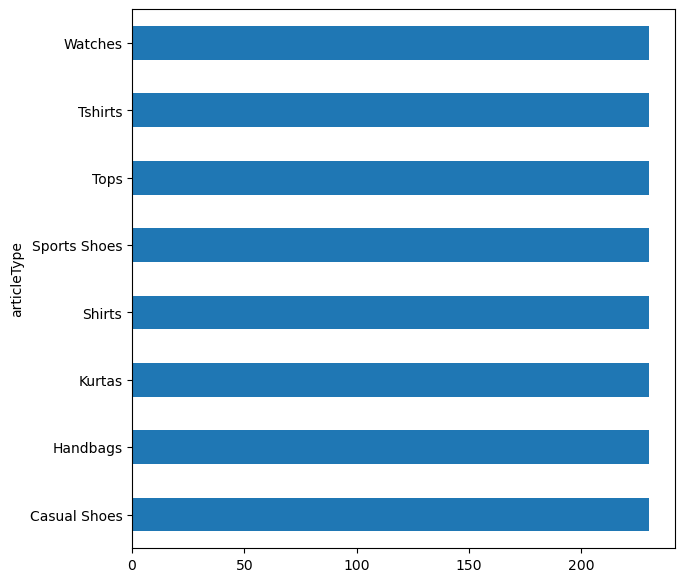

In [202]:
plt.figure(figsize=(7, 7))
balanced_df['articleType'].value_counts().sort_values().plot(kind='barh')
plt.show()


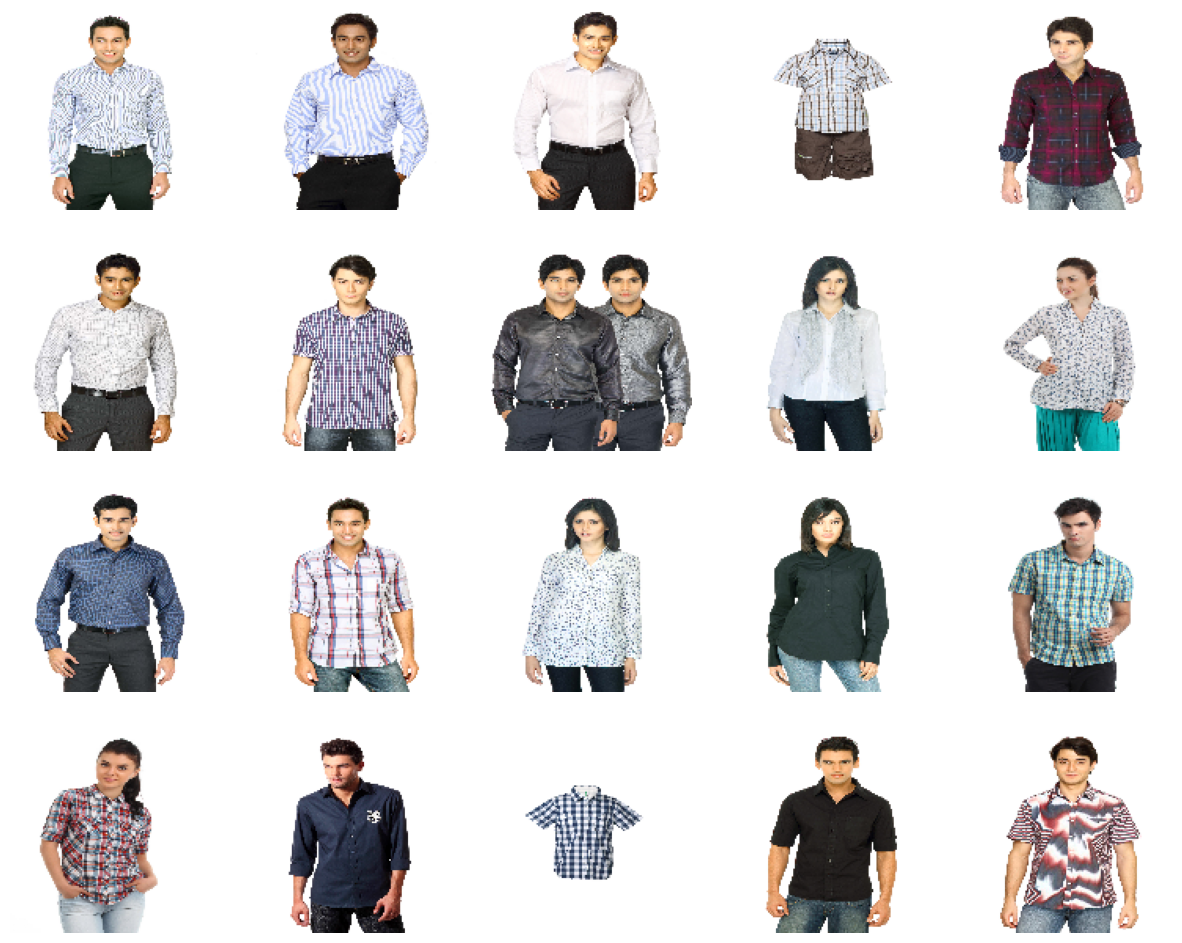

In [203]:
import matplotlib.pyplot as plt

# Define the desired article type
desired_article_type = 'Shirts'


filtered_rows = balanced_df[balanced_df['articleType'] == desired_article_type]

# Limit the number of images to be displayed to 20
filtered_rows = filtered_rows[:20]

# Determine the number of rows and columns for subplots
num_images = len(filtered_rows)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Display the images
plt.figure(figsize=(num_cols * 3, num_rows * 3))
for i, row in filtered_rows.iterrows():
    image = row['image_1']  # Get the preprocessed image from the DataFrame
    plt.subplot(num_rows, num_cols, i % 20 + 1)  # i % 20 + 1 ensures indexing within the subplot range
    plt.imshow(image)
    plt.axis('off')

plt.show()


In [204]:
balanced_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,image_1,articleType_encoded
0,5898,Men,Footwear,Shoes,Casual Shoes,Blue,Summer,2011,Casual,Puma Men Tekkies Jam Blue Shoe,5898.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
1,18405,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,Skechers Men USA Brown Shoe,18405.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
2,32951,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,2012,Casual,ADIDAS Neo Men Court Sequence Mid Brown Shoes,32951.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
3,41454,Men,Footwear,Shoes,Casual Shoes,White,Fall,2012,Casual,Lee Cooper Men White Shoes,41454.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
4,17813,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011,Casual,Lee Cooper Men Brown Casual Shoe,17813.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0


In [205]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Steff\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [206]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steff\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

# List to store user prompts
user_prompts = []

# Loop to continuously prompt the user and store prompts
while True:
    user_input = input("Enter your request (Enter 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    user_prompts.append(user_input)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text)
tfidf_matrix = tfidf_vectorizer.fit_transform(user_prompts)

print("TF-IDF Matrix:")
print(tfidf_matrix.toarray())

# Word Embeddings (Word2Vec)
tokenized_text_data = [preprocess_text(user_input) for user_input in user_prompts]
word2vec_model = Word2Vec(sentences=tokenized_text_data, vector_size=100, window=5, min_count=1, workers=4)

print("\nWord Embeddings:")
for word in word2vec_model.wv.index_to_key:
    print(word, ":", word2vec_model.wv[word])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Steff\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steff\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter your request (Enter 'exit' to quit): white top for women
Enter your request (Enter 'exit' to quit): black shoes
Enter your request (Enter 'exit' to quit): exit
TF-IDF Matrix:
[[0.         0.         0.57735027 0.57735027 0.57735027]
 [0.70710678 0.70710678 0.         0.         0.        ]]

Word Embeddings:
shoes : [-5.3622725e-04  2.3643136e-04  5.1033497e-03  9.0092728e-03
 -9.3029495e-03 -7.1168090e-03  6.4588725e-03  8.9729885e-03
 -5.0154282e-03 -3.7633716e-03  7.3805046e-03 -1.5334714e-03
 -4.5366134e-03  6.5540518e-03 -4.8601604e-03 -1.8160177e-03
  2.8765798e-03  9.9187379e-04 -8.2852151e-03 -9.4488179e-03
  7.3117660e-03  5.0702621e-03  6.7576934e-03  7.6286553e-04
  6.3508903e-03 -3.4053659e-03 -9.4640139e-04  5.7685734e-03
 -7.5216377e-03 -3.9361035e-03 -7.5115822e-03 -9.3004224e-04
  9.5381187e-03 -7.3191668e-03 -2.3337686e-03 -1.9377411e-03
  8.0774371e-03 -5.9308959e-03  4.5162440e-05 -4.7537340e-03
 -9.6035507e-03  5.0072931e-03 -8.7595852e-03 -4.3918253e-03
 -3.5

C:\Users\Steff\anaconda4\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [209]:
all_texts = balanced_df['productDisplayName'].unique()


# Tokenize and preprocess text
tokenized_text_data = [preprocess_text(user_input) for text in all_texts]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text_data, vector_size=100, window=5, min_count=1, workers=4)

# Extract word embeddings for each product title and description
word_embeddings = []
for text in tokenized_text_data:
    embedding = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    # Average word embeddings
    if embedding:
        embedding = sum(embedding) / len(embedding)
    else:
        embedding = [0] * word2vec_model.vector_size  # Handle out-of-vocabulary words
    word_embeddings.append(embedding)

print("\nWord Embeddings:")
print(word_embeddings[:10])


Word Embeddings:
[array([-5.3622725e-04,  2.3643136e-04,  5.1033497e-03,  9.0092728e-03,
       -9.3029495e-03, -7.1168090e-03,  6.4588725e-03,  8.9729885e-03,
       -5.0154282e-03, -3.7633716e-03,  7.3805046e-03, -1.5334714e-03,
       -4.5366134e-03,  6.5540518e-03, -4.8601604e-03, -1.8160177e-03,
        2.8765798e-03,  9.9187379e-04, -8.2852151e-03, -9.4488179e-03,
        7.3117660e-03,  5.0702621e-03,  6.7576934e-03,  7.6286553e-04,
        6.3508903e-03, -3.4053659e-03, -9.4640139e-04,  5.7685734e-03,
       -7.5216377e-03, -3.9361035e-03, -7.5115822e-03, -9.3004224e-04,
        9.5381187e-03, -7.3191668e-03, -2.3337686e-03, -1.9377411e-03,
        8.0774371e-03, -5.9308959e-03,  4.5162440e-05, -4.7537340e-03,
       -9.6035507e-03,  5.0072931e-03, -8.7595852e-03, -4.3918253e-03,
       -3.5099984e-05, -2.9618145e-04, -7.6612402e-03,  9.6147433e-03,
        4.9820580e-03,  9.2331432e-03, -8.1579173e-03,  4.4957981e-03,
       -4.1370760e-03,  8.2453608e-04,  8.4986202e-03, -4.

In [210]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [211]:
balanced_df['image']

0        5898.jpg
1       18405.jpg
2       32951.jpg
3       41454.jpg
4       17813.jpg
          ...    
1835    32367.jpg
1836    59262.jpg
1837    33877.jpg
1838    53562.jpg
1839    23284.jpg
Name: image, Length: 1840, dtype: object

In [212]:
balanced_df['articleType_encoded'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [213]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
num_classes=8

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])





In [214]:

image_dir = 'D:\\fas\\fashion-dataset\\images\\'


datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32
image_size = (224, 224)
generator = datagen.flow_from_dataframe(
    dataframe=balanced_df,
    directory=image_dir,
    x_col='image',
    y_col='articleType',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

features = model.predict(generator, verbose=1)


np.save('image_features.npy', features)

Found 1840 validated image filenames belonging to 8 classes.


C:\Users\Steff\anaconda4\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 1101s 19s/step


In [217]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,564,360 (105.15 MB)

 Trainable params: 12,849,672 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [288]:
features

array([[5.1161603e-11, 1.0410078e-08, 5.7353410e-03, ..., 9.9426186e-01,
        4.6139581e-09, 2.3034750e-06],
       [2.4490634e-08, 9.9994826e-01, 1.5937373e-07, ..., 5.1519175e-05,
        6.9533740e-13, 2.2504604e-10],
       [3.5497553e-11, 1.2282189e-07, 3.9333809e-04, ..., 9.9954647e-01,
        3.0088491e-14, 4.2545096e-07],
       ...,
       [6.3562868e-05, 4.8371871e-12, 3.5751049e-07, ..., 5.0914021e-08,
        7.0230379e-07, 9.9993289e-01],
       [3.0134210e-17, 1.9221989e-29, 2.6031238e-20, ..., 1.1089992e-16,
        2.8513799e-13, 1.0000000e+00],
       [4.5878625e-01, 4.9248266e-21, 3.2032318e-11, ..., 1.0330898e-09,
        1.4318158e-09, 5.4121375e-01]], dtype=float32)

In [289]:
features.shape

(1840, 8)

In [290]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

balanced_df['processed_description'] = balanced_df['productDisplayName'].apply(preprocess_text)

In [291]:
balanced_df['processed_description'] = balanced_df['articleType'].apply(preprocess_text)
balanced_df['processed_product_name'] = balanced_df['productDisplayName'].apply(preprocess_text)

In [292]:

tfidf_vectorizer_name = TfidfVectorizer(max_features=1840)
tfidf_matrix_name = tfidf_vectorizer_name.fit_transform(balanced_df['processed_product_name'])
tfidf_matrix_normalized_name = normalize(tfidf_matrix_name)

In [293]:
import numpy as np
from sklearn.preprocessing import normalize
image_features = np.load('image_features.npy')
image_features_normalized = normalize(image_features, axis=1)

In [294]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
import os

In [295]:
(tfidf_matrix_normalized_name.shape[1]) 

1134

In [296]:
len(image_features)

1840

In [297]:
from tensorflow.keras.layers import Concatenate, Dense, Input

from tensorflow.keras.models import Model

def build_fusion_model(tfidf_dim, image_dim, num_classes):
    text_input = Input(shape=(tfidf_dim,))
    image_input = Input(shape=(image_dim,))
    fusion_layer = Concatenate()([text_input, image_input])
    fusion_layer = Dense(256, activation='relu')(fusion_layer)
    fusion_layer = Dense(128, activation='relu')(fusion_layer)
    output = Dense(num_classes, activation='softmax')(fusion_layer)
    fusion_model = Model(inputs=[text_input, image_input], outputs=output)
    return fusion_model




In [298]:
print("Shape of tfidf_matrix_normalized_name:", tfidf_matrix_normalized_name.shape)
print("Shape of image_features:", image_features.shape)


Shape of tfidf_matrix_normalized_name: (1840, 1134)
Shape of image_features: (1840, 8)


In [299]:
num_classes = 8
fusion_model = build_fusion_model(tfidf_matrix_normalized_name.shape[1], image_features.shape[1], num_classes)

In [300]:
print("Input dimensions of the fusion model:")
print(fusion_model.input_shape)


Input dimensions of the fusion model:
[(None, 1134), (None, 8)]


In [301]:
print(fusion_model.summary())


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)   │ (None, 1134)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_54 (InputLayer)   │ (None, 8)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_21 (Concatenate)  │ (None, 1142)              │               0 │ input_layer_53[0][0],      │
│                               │                           │                 │ input_layer_54[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_67 (Dense)              │ (None, 256)               │         292,608 │ concatenate_21[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_68 (Dense)              │ (None, 128)               │          32,896 │ dense_67[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_69 (Dense)              │ (None, 8)                 │           1,032 │ dense_68[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 326,536 (1.25 MB)

 Trainable params: 326,536 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

None


In [302]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(balanced_df['articleType'])

# Convert the encoded labels to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)
print("Shape of one_hot_labels:", one_hot_labels.shape)
print("Shape of model output:", fusion_model.predict([tfidf_matrix_normalized_name, image_features]).shape)

# Compile and train the fusion model
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fusion_model_history=fusion_model.fit([tfidf_matrix_normalized_name, image_features], one_hot_labels, epochs=10, batch_size=32, validation_split=0.2)


Shape of one_hot_labels: (1840, 8)
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Shape of model output: (1840, 8)
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4264 - loss: 1.9248 - val_accuracy: 0.0000e+00 - val_loss: 3.4508
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8767 - loss: 0.7300 - val_accuracy: 0.2174 - val_loss: 4.3602
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9607 - loss: 0.1646 - val_accuracy: 0.2745 - val_loss: 4.7130
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9835 - loss: 0.0750 - val_accuracy: 0.2554 - val_loss: 4.9785
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9930 - loss: 0.0382 - val_accuracy: 0.2772 - val_loss: 5.1325
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9930 - loss: 0.0302 - val_accuracy: 0.2554 - val_loss: 5.3068
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9969 - loss: 0.0171 - val_accuracy: 0.2609 - val_loss: 5.3575
Epo

In [303]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape

def build_fusion_model_with_rnn(tfidf_dim, image_dim, num_classes):
    text_input = Input(shape=(tfidf_dim,))
    image_input = Input(shape=(image_dim,))
    
    # RNN layer for text data
    rnn_layer = Reshape((1, tfidf_dim))(text_input)
    rnn_layer = LSTM(128)(rnn_layer)
    
    # Concatenate text and image features
    fusion_layer = Concatenate()([rnn_layer, image_input])
    
    # Dense layers
    fusion_layer = Dense(256, activation='relu')(fusion_layer)
    fusion_layer = Dense(128, activation='relu')(fusion_layer)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(fusion_layer)
    
    # Create model
    fusion_model = Model(inputs=[text_input, image_input], outputs=output)
    return fusion_model


num_classes = 8
fusion_model_rnn = build_fusion_model_with_rnn(tfidf_matrix_normalized_name.shape[1], image_features.shape[1], num_classes)


In [304]:
print("Input dimensions of the fusion model:")
print(fusion_model_rnn.input_shape)

Input dimensions of the fusion model:
[(None, 1134), (None, 8)]


In [305]:
print(fusion_model_rnn.summary())

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)   │ (None, 1134)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_2 (Reshape)           │ (None, 1, 1134)           │               0 │ input_layer_55[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 128)               │         646,656 │ reshape_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_56 (InputLayer)   │ (None, 8)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_22 (Concatenate)  │ (None, 136)               │               0 │ lstm_2[0][0],              │
│                               │                           │                 │ input_layer_56[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_70 (Dense)              │ (None, 256)               │          35,072 │ concatenate_22[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_71 (Dense)              │ (None, 128)               │          32,896 │ dense_70[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_72 (Dense)              │ (None, 8)                 │           1,032 │ dense_71[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 715,656 (2.73 MB)

 Trainable params: 715,656 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [306]:
print("Shape of input text data (tfidf_matrix_normalized_name):", tfidf_matrix_normalized_name.shape)
print("Shape of input image data (image_features):", image_features.shape)


Shape of input text data (tfidf_matrix_normalized_name): (1840, 1134)
Shape of input image data (image_features): (1840, 8)


In [307]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(balanced_df['articleType'])

# Convert the encoded labels to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)
print("Shape of one_hot_labels:", one_hot_labels.shape)
print("Shape of model output:", fusion_model.predict([tfidf_matrix_normalized_name, image_features]).shape)


Shape of one_hot_labels: (1840, 8)
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Shape of model output: (1840, 8)


In [308]:
# Convert sparse matrix to dense array
tfidf_matrix_dense = tfidf_matrix_normalized_name.toarray()

# Build fusion model with RNN
fusion_model_rnn = build_fusion_model_with_rnn(tfidf_matrix_dense.shape[1], image_features.shape[1], num_classes)

# Compile and train the fusion model with RNN
fusion_model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fusion_model__rnn_history=fusion_model_rnn.fit([tfidf_matrix_dense, image_features], one_hot_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2813 - loss: 1.9656 - val_accuracy: 0.0000e+00 - val_loss: 3.7585
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6516 - loss: 1.0731 - val_accuracy: 0.0679 - val_loss: 5.3787
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9466 - loss: 0.2059 - val_accuracy: 0.3125 - val_loss: 6.4175
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9660 - loss: 0.0966 - val_accuracy: 0.3016 - val_loss: 7.0544
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9914 - loss: 0.0408 - val_accuracy: 0.2772 - val_loss: 7.3679
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9948 - loss: 0.0237 - val_accuracy: 0.2473 - val_loss: 7.8536
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9945 - loss: 0.0193 - val_accuracy: 0.3152 - val_loss: 8.0572
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9900 - loss: 0.0284 - val_accuracy: 0.2989

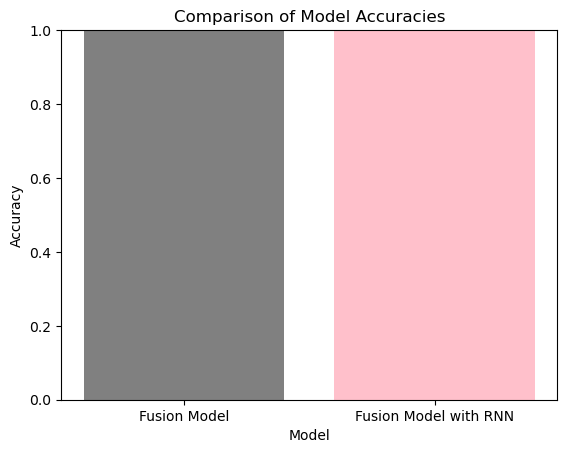

In [311]:
fusion_model_accuracy = fusion_model_history.history['accuracy'][-1]
fusion_model_rnn_accuracy = fusion_model__rnn_history.history['accuracy'][-1]
models = ['Fusion Model', 'Fusion Model with RNN']
accuracies = [fusion_model_accuracy, fusion_model_rnn_accuracy]

plt.bar(models, accuracies, color=['grey', 'pink'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1) 
plt.show()

In [312]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

validation_predictions = fusion_model.predict([tfidf_matrix_normalized_name, image_features])

validation_labels = one_hot_labels

predicted_classes = np.argmax(validation_predictions, axis=1)
true_classes = np.argmax(validation_labels, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Calculate mean average precision (MAP)
average_precision = average_precision_score(validation_labels, validation_predictions, average='weighted')

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Mean Average Precision (MAP):", average_precision)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precision: 0.757842968596796
Recall: 0.8581521739130434
F1-score: 0.8036535188767978
Mean Average Precision (MAP): 0.9849296609629534


C:\Users\Steff\anaconda4\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [317]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from scipy.sparse import csr_matrix

tfidf_matrix_normalized_name_dense = tfidf_matrix_normalized_name.toarray()

validation_predictions_rnn = fusion_model_rnn.predict([tfidf_matrix_normalized_name_dense, image_features])

validation_labels = one_hot_labels

predicted_classes_rnn = np.argmax(validation_predictions_rnn, axis=1)
true_classes = np.argmax(validation_labels, axis=1)

# Calculate precision, recall, and F1-score for Fusion Model with RNN
precision_rnn = precision_score(true_classes, predicted_classes_rnn, average='weighted')
recall_rnn = recall_score(true_classes, predicted_classes_rnn, average='weighted')
f1_rnn = f1_score(true_classes, predicted_classes_rnn, average='weighted')

# Calculate mean average precision (MAP) for Fusion Model with RNN
average_precision_rnn = average_precision_score(validation_labels, validation_predictions_rnn, average='weighted')

# Print the evaluation metrics for Fusion Model with RNN
print("Precision (Fusion Model with RNN):", precision_rnn)
print("Recall (Fusion Model with RNN):", recall_rnn)
print("F1-score (Fusion Model with RNN):", f1_rnn)
print("Mean Average Precision (MAP) (Fusion Model with RNN):", average_precision_rnn)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precision (Fusion Model with RNN): 0.7729772806157617
Recall (Fusion Model with RNN): 0.8554347826086957
F1-score (Fusion Model with RNN): 0.80833560602161
Mean Average Precision (MAP) (Fusion Model with RNN): 0.9712139773405467


C:\Users\Steff\anaconda4\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [330]:
image_features

array([[5.1161603e-11, 1.0410078e-08, 5.7353410e-03, ..., 9.9426186e-01,
        4.6139581e-09, 2.3034750e-06],
       [2.4490634e-08, 9.9994826e-01, 1.5937373e-07, ..., 5.1519175e-05,
        6.9533740e-13, 2.2504604e-10],
       [3.5497553e-11, 1.2282189e-07, 3.9333809e-04, ..., 9.9954647e-01,
        3.0088491e-14, 4.2545096e-07],
       ...,
       [6.3562868e-05, 4.8371871e-12, 3.5751049e-07, ..., 5.0914021e-08,
        7.0230379e-07, 9.9993289e-01],
       [3.0134210e-17, 1.9221989e-29, 2.6031238e-20, ..., 1.1089992e-16,
        2.8513799e-13, 1.0000000e+00],
       [4.5878625e-01, 4.9248266e-21, 3.2032318e-11, ..., 1.0330898e-09,
        1.4318158e-09, 5.4121375e-01]], dtype=float32)

In [351]:
def image_display(text):
    desired_article_type = text
    filtered_rows = filtered_df[filtered_df['productDisplayName'] == desired_article_type]

    # Extract the filenames of the images corresponding to the selected article type
    image_filenames = filtered_rows['id'].apply(lambda x: str(x) + ".jpg").tolist()

    # Define the directory where the images are stored
    image_directory = 'D:\\fas\\fashion-dataset\\images\\' 

    # Limit the number of images to be displayed to 20
    image_filenames = image_filenames[:20]

    # Determine the number of rows and columns for subplots
    num_images = len(image_filenames)
    num_rows = (num_images - 1) // 5 + 1
    num_cols = min(num_images, 5)

    # Display the images
    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    for i, filename in enumerate(image_filenames):
        image_path = os.path.join(image_directory, filename)
        image = Image.open(image_path)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


Enter your prompt: black shoe for women
Top 1 - Display Name: Puma Men Tekkies Jam Blue Shoe, Article Type: Casual Shoes


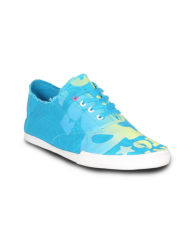

Top 2 - Display Name: Skechers Men USA Brown Shoe, Article Type: Casual Shoes


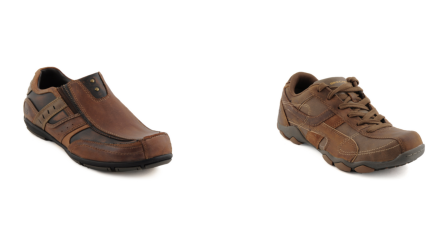

Top 3 - Display Name: ADIDAS Neo Men Court Sequence Mid Brown Shoes, Article Type: Casual Shoes


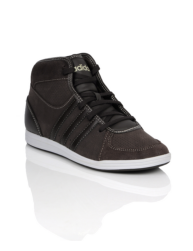

Top 4 - Display Name: Lee Cooper Men White Shoes, Article Type: Casual Shoes


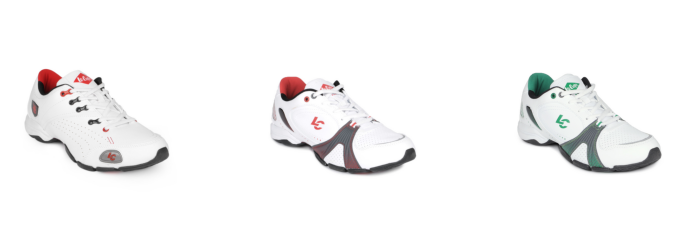

Top 5 - Display Name: Lee Cooper Men  Brown Casual Shoe, Article Type: Casual Shoes


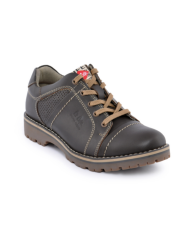

Top 6 - Display Name: Puma Women Black Karmin Lace Shoes, Article Type: Casual Shoes


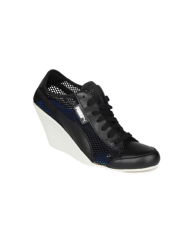

Top 7 - Display Name: Puma Women Saba Ballet DC3 Purple Casual Shoes, Article Type: Casual Shoes


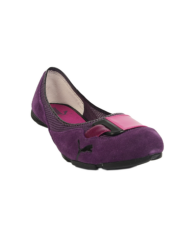

Top 8 - Display Name: Flying Machine Men Brown Shoes, Article Type: Casual Shoes


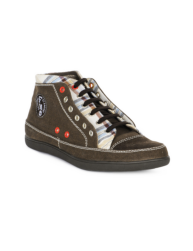

Top 9 - Display Name: Gas Men Jack Grey Shoes, Article Type: Casual Shoes


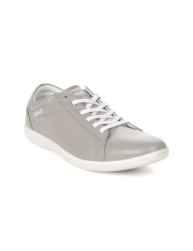

Top 10 - Display Name: Converse Unisex Black Casual Shoes, Article Type: Casual Shoes


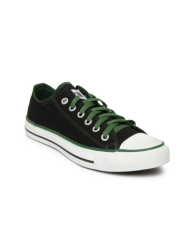

0                   Puma Men Tekkies Jam Blue Shoe
1                      Skechers Men USA Brown Shoe
2    ADIDAS Neo Men Court Sequence Mid Brown Shoes
3                       Lee Cooper Men White Shoes
4                Lee Cooper Men  Brown Casual Shoe
Name: productDisplayName, dtype: object


In [352]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

def get_top_similar_images(user_prompt, product_display_names, article_types, image_features, tfidf_vectorizer, tokenizer, num_images=10):
    # Tokenize user prompt
    user_tokens = tokenizer.texts_to_sequences([user_prompt])
    user_tokens = pad_sequences(user_tokens, maxlen=MAX_SEQUENCE_LENGTH)
    tfidf_description = tfidf_vectorizer.transform([user_prompt])

    tfidf_description = np.repeat(tfidf_description.toarray(), article_types.shape[0], axis=0)

    label_encoder = LabelEncoder()
    encoded_article_types = label_encoder.fit_transform(article_types)

    # Calculate cosine similarity between user prompt and article types
    combined_features = np.hstack([tfidf_description, encoded_article_types.reshape(-1, 1)])
    similarity_scores = cosine_similarity(combined_features)

    if similarity_scores.size == 0:
        print("No matching products found.")
        return None

    # Find the index of the article type with the highest similarity score
    max_similarity_index = np.argmax(similarity_scores)

    # Check if max similarity index is within bounds
    if max_similarity_index >= len(article_types):
        print("Error: Max similarity index out of bounds.")
        return None

    selected_article_type = article_types.iloc[max_similarity_index]

    filtered_display_names = product_display_names[article_types == selected_article_type]

    # Display or print top N images for the selected article type
    for i, display_name in enumerate(filtered_display_names[:num_images], start=1):
        print(f"Top {i} - Display Name: {display_name}, Article Type: {selected_article_type}")
        image_display(display_name)
        
    return selected_article_type


user_prompt = input("Enter your prompt: ")
selected_article_type = get_top_similar_images(user_prompt, balanced_df['productDisplayName'], balanced_df['articleType'], image_features, tfidf_vectorizer, tokenizer)
if selected_article_type is not None:
    filtered_display_names = balanced_df['productDisplayName'][balanced_df['articleType'] == selected_article_type]
    print(filtered_display_names[:5])


In [98]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = vgg_model.predict(x)
    return features.flatten()

# Path to the directory containing the images
image_dir = 'D:\\fas\\fashion-dataset\\images\\'

# Extract features for each image
features_list = []
for img_filename in balanced_df['image']:
    img_path = os.path.join(image_dir, img_filename)
    features = extract_features(img_path)
    features_list.append(features)

# Convert the list of features into a numpy array
features_array = np.array(features_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

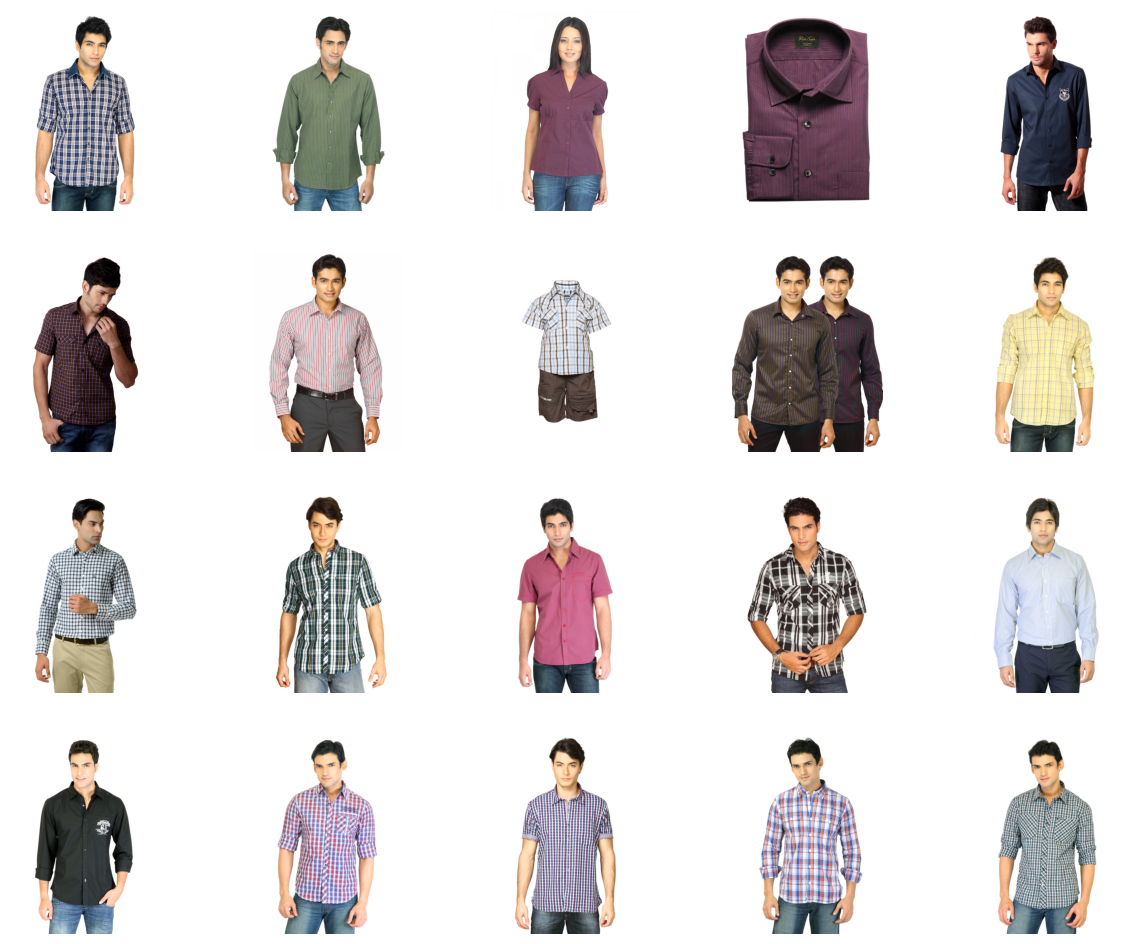

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import os


desired_article_type = 'Shirts'

# Filter the DataFrame to select rows with the desired article type
filtered_rows = filtered_df[filtered_df['articleType'] == desired_article_type]

# Extract the filenames of the images corresponding to the selected article type
image_filenames = filtered_rows['id'].apply(lambda x: str(x) + ".jpg").tolist()

# Define the directory where the images are stored
image_directory = 'D:\\fas\\fashion-dataset\\images\\'  # Change this to your image directory path

# Limit the number of images to be displayed to 20
image_filenames = image_filenames[:20]

# Determine the number of rows and columns for subplots
num_images = len(image_filenames)
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Display the images
plt.figure(figsize=(num_cols * 3, num_rows * 3))
for i, filename in enumerate(image_filenames):
    image_path = os.path.join(image_directory, filename)
    image = Image.open(image_path)
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

